# Problem sheet 4 - Q5: Q-learning

1. [The setup](#1)
2. [Q-learning implementation](#2)
3. [Animation](#3)
4. [Next steps](#4)

We now move on to a completely different topic of reinforcement learning. Here we typically have some system consisting of a set of possible states $S$ and a set of allowed state transitions (also called *actions*) A. In other words for any $a\in A$ we get a mapping $a:S\to S$. Moreover, to each state and action we also associate a reward given by the *reward function* $R_{a}:S\times S\to\mathbb{R}$, where $R_{a}(s, s')$ gives the reward for reaching state $s'$ from state $s$ by taking action $a$. Our task is to construct a function $\mathcal{Q}(s, a)$ which measures the quality (with respect to maximising the expected reward over time) of taking action $a$ in state $s$. Once we have such a function we can construct an agent, for example, by greedily picking $\mathop{\mathrm{argmax}}_{a}Q(s, a)$ in a given state $s$ (this is also called the *policy* of our model). As described, the above is a completely deterministic process and therefore not so interesting for practical purposes. Therefore we also include a set of distributions $p_{a}$, where $p_{a}(s'|s)$ is the probability of reaching state $s'$ from $s$ by taking action $a$. This has the dual purpose of introducing noise to the process and capturing the uncertainty in e.g. performing difficult actions). In the setup of the current problem these probabilities are unknown and our model will have to learn them (implicitly).

So how do we find $\mathcal{Q}$? Let's suppose we learn some policy $\pi$. To this $\pi$ we associate a value function $V^{\pi}(s)$, which measures the expected reward if we start from state $s$ and follow the policy $\pi$.
For a fixed $\pi$ and initial state we obtain a sequence of states and actions $(s_{i}, a_{i})_{i=0}$, where $s_0=s$, $s_{i}=a_{i-1}(s_{i-1})$ and $a_{i}=\pi(s_{i})$. The value function is then given by
$$V^{\pi}(s)= \mathbb{E}\bigl[\sum_{i}\gamma^{i}R_{a_{i}}(s_{i}, s_{i+1})\;\big|\; s_{0}=s\bigr],$$
where $0<\gamma<1$ is the so-called *discount factor*, which captures the uncertainty of reaching a state far into the future (e.g. in each time step our agent could have a small chance of terminating, which incentivises obtaining positive rewards as soon as possible). $\gamma$ also ensures that the above series converges (for bounded rewards). The cornerstone of the $Q$-learning algorithm is that $V^{\pi}$ satisfies a recursive equation called [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation):
$$V^{\pi}(s) = R_{\pi}(s) + \gamma\sum_{s'\in S}p_{\pi(s)}(s'|s)V^{\pi}(s'),$$
where $R_\pi(s)$ denotes the immediate reward for being in state $s$.
Essentially this is saying that the expected reward is a sum of the immediate reward and the expected rewards of all possible subsequent states weighted by their probability (i.e. it's the expectation of $V^{\pi}$ w.r.t. $p_{\pi(s)}$). If we consider the immediate reward as a mean of the rewards $R_{\pi(s)}(s, s')$ where $s'|s\sim p_{\pi(s)}$, then we can rewrite the Bellman equation and define our objective function as
$$\mathcal{Q}^{\ast}(s, a) = \sum_{s'}p_{a}(s'|s)(R_{a}(s, s') + \gamma V^{\pi}(s')),$$
where $a=\pi(s)$.
Since the state transition probabilities are unknown, we have to devise an algorithm that produces a function which we hope converges to $\mathcal{Q}^{\ast}$. The Q-learning algorithm does this in the following way:

1. Initialise $\mathcal{Q}(s, a)$ to some arbitrary values for each $s\in S$ and $a\in A$ and construct an initial greedy policy $\pi$.
2. Starting from $t=0$ update the value of $\mathcal{Q}$ by
$$\mathcal{Q}(s_{t}, a_{t}):=\mathcal{Q}(s_{t}, a_{t}) + \alpha\bigl(R_{\pi}(s) + \gamma\max_{a}\mathcal{Q}(\pi(s), a) - \mathcal{Q}(s, a_{t})\bigr),$$
until reaching the terminal state, where $\pi$ always corresponds to the greedy policy.
3. Repeat 2. for the required number of *episodes* to reach a suitable estimate for $\mathcal{Q}^{\ast}$.




## 1. The setup<a id="1"></a>
In this exercise we consider the classical example of a mountain car trying to climb up the hill (Sutton and Barto, 1998):

!['Mountain car'](car.jpg 'Mountain car')

The car starts on the slope and in each iteration we have two possible actions $a=\pm1$, where the positive sign corresponds to accelerating forward and the minus sign to reversing backwards. We first establish some helper functions which have been adapted from the Matlab code provided as part of the problem sheet:
- `move_car(x, a)` controls the dynamics of the car in state x if it takes the action a, returns the next position of the car `x_next`, its index `s_idx` and the variable `absorb` which tells us whether the car has reached the terminal position.
- `plot_car(x, ax)` draws the car in position x onto the axis ax.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import sleep

In [2]:
def move_car(x, a):
    x = np.asarray(x)
    x_next = np.zeros(2)
    x_next[1] = x[1] + 0.001 * a - 0.0025 * np.cos(3 * x[0])
    x_next[0] = x[0] + x_next[1]
    
    # clip
    absorb = False
    if x_next[0] < -1.2:
        x_next[1] = 0
    elif x_next[0] > 0.5:
        absorb = True
        
    x_next[0] = max(min(x_next[0], 0.5), -1.2)
    x_next[1] = max(min(x_next[1], 0.07), -0.07)
    
    # find idx
    
    s_idx = int(10 * np.floor(10 * (x_next[0] + 1.2)/(1.7 + 1e-10))
                + np.floor(10 * (x_next[1] + 0.07)/(0.14 + 1e-10)))
    
    return x_next, s_idx, absorb

In [3]:
def plot_car(x, ax):
    ax.clear()
    x = np.asarray(x)
    xcoords = np.arange(-1.3, 0.6, 0.01)
    
    def f(x):
        return 0.3 * np.sin(3 * x)
    
    ax.plot(xcoords, f(xcoords), 'k-')

    def f_prime(x):
        return 3 * 0.3 * np.cos(3 * x)
    
    theta = np.arctan2(f_prime(x[0]), 1.)
    y = f(x[0])
    
    car = np.array([[-0.05, 0.05],
                    [0.05, 0.05],
                    [0.05, 0.01],
                    [-0.05, 0.01],
                    [-0.05, 0.05]]).T
    fwheel = np.array([0.035 + 0.01 * np.cos(np.arange(0, 2*np.pi, 0.5)),
                       0.01 + 0.01 * np.sin(np.arange(0, 2*np.pi, 0.5))])
    rwheel = np.array([-0.035 + 0.01 * np.cos(np.arange(0, 2*np.pi, 0.5)),
                       0.01 + 0.01 * np.sin(np.arange(0, 2*np.pi, 0.5))])
    
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])

    car = R @ car + np.array([[x[0], y]]).T
    fwheel = R @ fwheel + np.array([[x[0], y]]).T
    rwheel = R @ rwheel + np.array([[x[0], y]]).T
    
    ax.plot(car[0, :], car[1, :], c='blue')
    ax.plot(fwheel[0, :], fwheel[1, :], c='navy')
    ax.plot(rwheel[0, :], rwheel[1, :], c='navy')
    
    ax.axis('equal')
    ax.set(xlim=(-1.3, 0.6), ylim=(-0.4, 0.4))

    
    fig.canvas.draw()
    fig.canvas.flush_events()

## 2. Q-learning implementation<a id="2"></a>

We can now construct a function according to the iteration described in the introduction. The state space consists of 100 values along the $x$-axis between -1.2 and 0.5 and as mentioned before $A=\{\pm1\}$. We also set the reward to -1 everywhere except at the top of the hill (where it's 0). To introduce stochasticity, we move the car in the first iteration in a random direction. Also if there is no unique optimal action based on $\mathcal{Q}(s, a)$, we pick one at random.

In [4]:
def qlearn(episodes, alpha=0.05, gamma=0.99):
    num_states = 100
    num_actions = 2
    actions = [-1, 1]
    Q = np.zeros((num_states, num_actions))
    steps_per_episode = np.zeros(episodes)
    
    for i in range(episodes):
        x, s, absorb = move_car([0.0, -np.pi/6], 0)
        steps = 0
        
        rng = np.random.default_rng()
        a = rng.choice(actions)
        
        while not absorb:
            x, s_prime, absorb = move_car(x, actions[a])
            
            if np.min(Q[s_prime, :]) == np.max(Q[s_prime, :]):
                a_prime = rng.choice(np.arange(len(actions)))
            else:
                a_prime = np.argmax(Q[s_prime, :])


            reward = - int(absorb == 0)
            Q[s, a] = ((1 - alpha) * Q[s, a] + alpha *
                       (reward + gamma * Q[s_prime, a_prime]))
            s = s_prime
            a = a_prime
            steps += 1
        
        steps_per_episode[i] = steps
        
    return Q, steps_per_episode

We can now run the above algorithm to obtain our estimated $\mathcal{Q}^{\ast}$. One caveat of Q-learning (and most reinforcement learning algorithms in general) is that it is extremely inefficient. In practice this means that we have to run the simulation for a huge number of episodes. Even for this fairly simple task we need many thousands of iterations to converge towards the optimal solution. We'll run our implementation 10 times for 10 000 episodes each.

In [5]:
%%time
iters = 10
episodes = 10000
all_ep_steps = np.zeros((iters, episodes))

for i in range(iters):
    Q, ep_steps = qlearn(episodes)
    all_ep_steps[i, :] = ep_steps
                         
print(all_ep_steps.shape)

(10, 10000)
CPU times: user 4min 9s, sys: 2.42 s, total: 4min 11s
Wall time: 4min 13s


The variance between consequent episodes is very high. On top of that, the variance between different runs of the same algorithm is also high, because sometimes the system can get stuck in a bad state early and it can take a long time before the algorithm manages to escape it. To visualise this we take a running average over 100 steps (with `np.convolve`) of the mean at each episode across the 10 iterations. Even with all this averaging we end up with an extremely jittery graph.

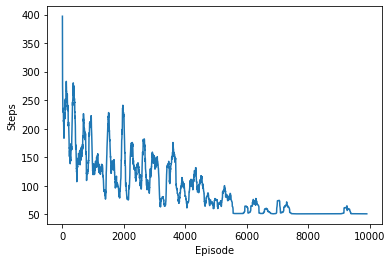

In [6]:
%matplotlib inline
plt.plot(np.convolve(np.mean(all_ep_steps, axis=0), np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.show()

To show the variance between different iterations of the same algorithm, we repeat the above plot, but now averaged over only 2 runs of the algorithm so that we end up with 5 different curves.

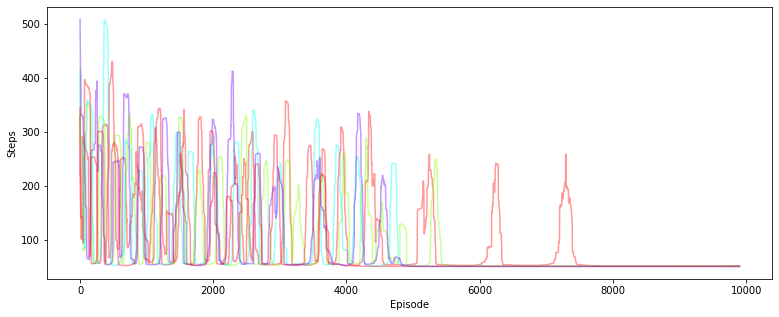

In [7]:
cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=4)
plt.figure(figsize=(13,5))
plt.xlabel('Episode')
plt.ylabel('Steps')
for i in range(5):
    plt.plot(np.convolve(np.mean(all_ep_steps[i:i+1,:], axis=0), np.ones(100)/100, mode='valid'), c=cmap(norm(i)), alpha=0.4)
plt.show()

## 3. Animation<a id="3"></a>
After we have finished learning our $\mathcal{Q}$, we can visualise the resulting policy $\pi$ with the help of the following animation. Run both cells to see the result. It could be possible to optain a slightly more optimal policy by consider all the final $\mathcal{Q}$'s that we learned (there are 10 of them) and to average over them. But as we see from the previous plots, it's likely that they are all fairly similar once we reach convergence after about 6000 episodes.

<font color="#aaa">(not available in the static html version)</font>

<IPython.core.display.Javascript object>


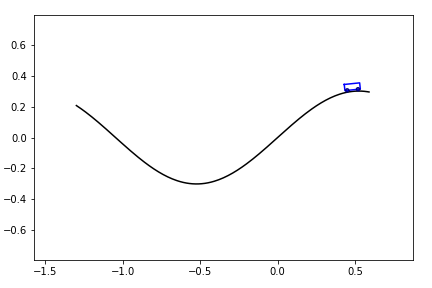

In [8]:
%matplotlib nbagg
fig, ax = plt.subplots(figsize=(6,4));
plt.tight_layout()

In [9]:
x, s, absorb = move_car([0.0, -np.pi/6], 0)
actions = [-1, 1]

while not absorb:
    plot_car(x, ax)
    x, s, absorb = move_car(x, actions[np.argmax(Q[s,:])])
    sleep(0.0001)

## 4. Next steps<a id="4"></a>
- Since we have a simulator, we can use this to approximate the state transition probabilities and then use some other value/policy iteration algorithm with the estimated probabilities.
- In our answer we discretised our state space to 100 different states. It would be interesting to apply an algorithm meant for continuous state spaces, such as fitted value iteration, again by using the (approximate) learned state transition probabilities.
- Finally, we want to extend to other interesting dynamical systems such as billiards. In particular for an appropriate choice for the boundary of the billiard we would end up with an ergodic system and we could see how well these algorithms tackle that situation.